## WITH ZZ COUPLING TO TLS

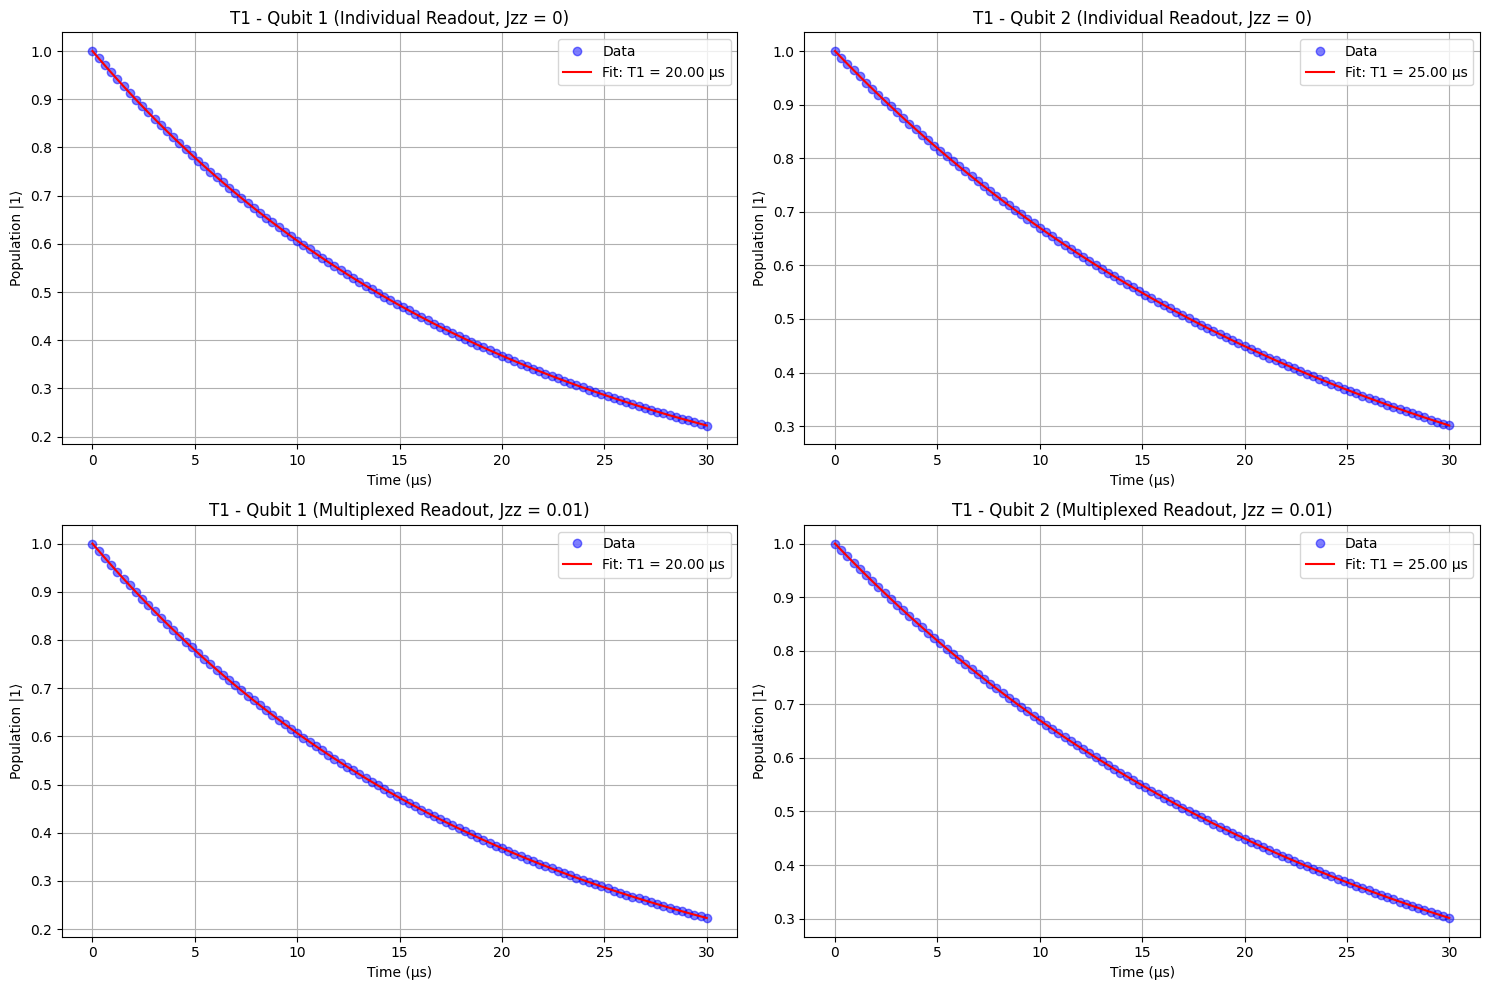

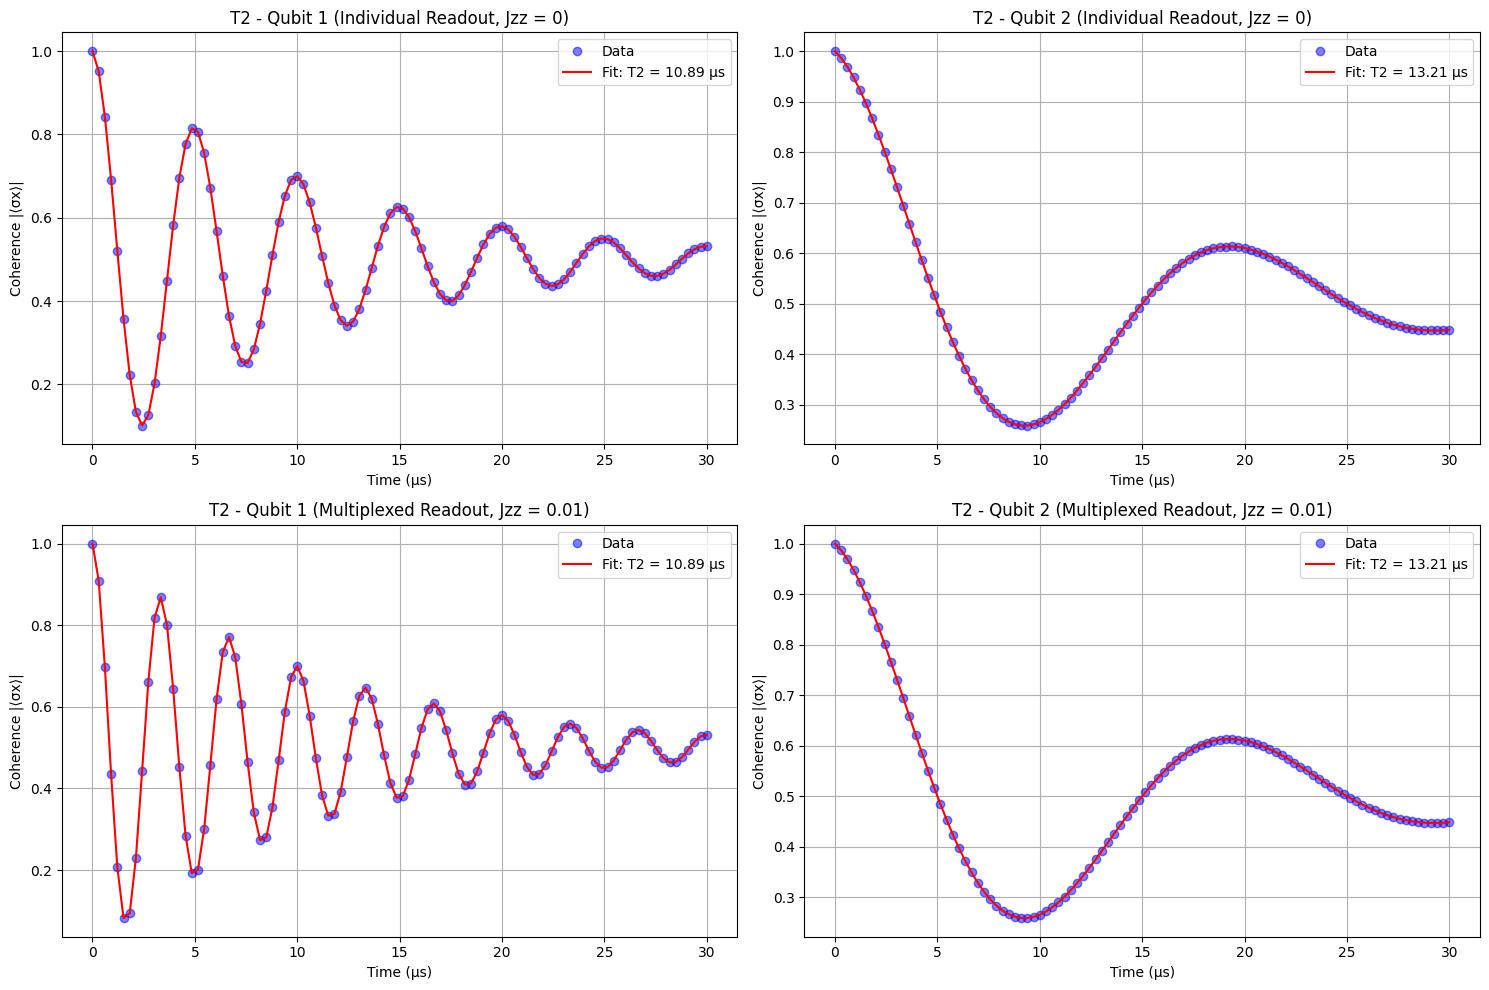

T1 Measurements:
----------------
Individual Readout (Jzz = 0):
Qubit 1: T1 = 20.00 μs
Qubit 2: T1 = 25.00 μs

Multiplexed Readout (Jzz = 0.01):
Qubit 1: T1 = 20.00 μs
Qubit 2: T1 = 25.00 μs

T2 Measurements:
----------------
Individual Readout (Jzz = 0):
Qubit 1: T2 = 0.00 μs
Qubit 2: T2 = 0.00 μs

Multiplexed Readout (Jzz = 0.01):
Qubit 1: T2 = 0.00 μs
Qubit 2: T2 = 0.00 μs


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, tensor, sigmaz, sigmax, sigmam, sigmap, mesolve, identity
from scipy.optimize import curve_fit
from qtt.algorithms.functions import gauss_ramsey, fit_gauss_ramsey, plot_gauss_ramsey_fit

# System parameters
fq1 = 3.2  # GHz, Qubit 1 frequency
fq2 = 3.35  # GHz, Qubit 2 frequency
fTLS = 3.2  # GHz, TLS frequency (resonant with Qubit 1)
J_TLS = 0.05  # GHz, Coupling strength between Qubit 1 and TLS

# Relaxation and dephasing rates
gamma1_q1 = 1/20  # Relaxation rate for qubit 1 (T1 ~ 20 μs)
gamma2_q1 = 1/15  # Dephasing rate for qubit 1 (T2 ~ 15 μs)
gamma1_q2 = 1/25  # Relaxation rate for qubit 2 (T1 ~ 25 μs)
gamma2_q2 = 1/18  # Dephasing rate for qubit 2 (T2 ~ 18 μs)
gamma1_TLS = 1/5  # Relaxation rate for TLS
gamma2_TLS = 1/3  # Dephasing rate for TLS

# Time parameters
tlist = np.linspace(0, 30, 100)  # Time points in μs

# Define operators for different configurations
def setup_operators(use_zz_coupling=True):
    # ZZ coupling strength
    Jzz = 0.05 if use_zz_coupling else 0.0
    
    # Define operators in combined Hilbert space (Qubit 1, Qubit 2, TLS)
    sz_q1 = tensor(sigmaz(), identity(2), identity(2))
    sz_q2 = tensor(identity(2), sigmaz(), identity(2))
    sz_tls = tensor(identity(2), identity(2), sigmaz())
    
    sx_q1 = tensor(sigmax(), identity(2), identity(2))
    sx_q2 = tensor(identity(2), sigmax(), identity(2))
    
    sm_q1 = tensor(sigmam(), identity(2), identity(2))
    sm_q2 = tensor(identity(2), sigmam(), identity(2))
    sm_tls = tensor(identity(2), identity(2), sigmam())
    
    # Construct Hamiltonian components
    H_Q1 = 2*np.pi * fq1/2 * sz_q1
    H_Q2 = 2*np.pi * fq2/2 * sz_q2
    H_TLS = 2*np.pi * fTLS/2 * sz_tls
    H_ZZ = 2*np.pi * Jzz * sz_q1 * sz_q2
    H_Q1_TLS = 2*np.pi * J_TLS * sz_q1 * sz_tls
    
    # Total Hamiltonian
    #H = H_Q1 + H_Q2 
    H = H_Q1 + H_Q2 + H_ZZ + H_TLS + H_Q1_TLS

    # Collapse operators
    c_ops = []
    c_ops.append(np.sqrt(gamma1_q1) * sm_q1)  # T1 for qubit 1
    #c_ops.append(np.sqrt(gamma2_q1/2) * sm_q1.dag())  # Pure dephasing for qubit 1
    c_ops.append(np.sqrt(gamma2_q1/2) * sz_q1)  # Pure dephasing for qubit 1
    c_ops.append(np.sqrt(gamma1_q2) * sm_q2)  # T1 for qubit 2
    c_ops.append(np.sqrt(gamma2_q2/2) * sz_q2)  # Pure dephasing for qubit 2
    c_ops.append(np.sqrt(gamma1_TLS) * sm_tls)  # T1 for TLS
    c_ops.append(np.sqrt(gamma2_TLS/2) * sz_tls)  # Pure dephasing for TLS
    
    return H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2

# Fitting function for T1 decay
def exp_decay(t, a, T1, c):
    return a * np.exp(-t / T1) + c

# Define the Ramsey function
def ramsey(t, A, T2_star, f, phi, C):
    return A * np.exp(-t/T2_star) * np.cos(2*np.pi*f*t + phi) + C

para_d =  [4.6e-01,  5.4e-06,  1.3e+05, -1.6e+00, 5.0e-01] # close enough I hope

# --- T1 MEASUREMENTS ---

# 1. Individual Readout (Jzz = 0)
H_ind, c_ops_ind, sz_q1_ind, sz_q2_ind, sx_q1_ind, sx_q2_ind, sm_q1_ind, sm_q2_ind = setup_operators(use_zz_coupling=False)

# T1 measurement for Qubit 1 (individual)
psi0_q1_ind = tensor(basis(2, 0), basis(2, 1), basis(2, 1))  # |1⟩|0⟩|0⟩
result_q1_t1_ind = mesolve(H_ind, psi0_q1_ind, tlist, c_ops_ind, [sz_q1_ind])
pop_q1_ind = (1 + result_q1_t1_ind.expect[0]) / 2  # Convert <σz> to |1⟩ population

# Fit T1 for Qubit 1 (individual)
popt_q1_t1_ind, _ = curve_fit(exp_decay, tlist, pop_q1_ind, p0=[1.0, 20, 0])
T1_q1_ind = popt_q1_t1_ind[1]

# T1 measurement for Qubit 2 (individual)
psi0_q2_ind = tensor(basis(2, 1), basis(2, 0), basis(2, 1))  # |0⟩|1⟩|0⟩
result_q2_t1_ind = mesolve(H_ind, psi0_q2_ind, tlist, c_ops_ind, [sz_q2_ind])
pop_q2_ind = (1 + result_q2_t1_ind.expect[0]) / 2  # Convert <σz> to |1⟩ population

# Fit T1 for Qubit 2 (individual)
popt_q2_t1_ind, _ = curve_fit(exp_decay, tlist, pop_q2_ind, p0=[1.0, 25, 0])
T1_q2_ind = popt_q2_t1_ind[1]

# 2. Multiplexed Readout (Jzz ≠ 0)
H_mult, c_ops_mult, sz_q1_mult, sz_q2_mult, sx_q1_mult, sx_q2_mult, sm_q1_mult, sm_q2_mult = setup_operators(use_zz_coupling=True)

# T1 measurement for Qubit 1 (multiplexed)
psi0_q1_mult = tensor(basis(2, 0), basis(2, 1), basis(2, 0))  # |1⟩|0⟩|0⟩
result_q1_t1_mult = mesolve(H_mult, psi0_q1_mult, tlist, c_ops_mult, [sz_q1_mult])
pop_q1_mult = (1 + result_q1_t1_mult.expect[0]) / 2

# Fit T1 for Qubit 1 (multiplexed)
popt_q1_t1_mult, _ = curve_fit(exp_decay, tlist, pop_q1_mult, p0=[1.0, 20, 0])
T1_q1_mult = popt_q1_t1_mult[1]

# T1 measurement for Qubit 2 (multiplexed)
psi0_q2_mult = tensor(basis(2, 1), basis(2, 0), basis(2, 1))  # |0⟩|1⟩|0⟩
result_q2_t1_mult = mesolve(H_mult, psi0_q2_mult, tlist, c_ops_mult, [sz_q2_mult])
pop_q2_mult = (1 + result_q2_t1_mult.expect[0]) / 2

# Fit T1 for Qubit 2 (multiplexed)
popt_q2_t1_mult, _ = curve_fit(exp_decay, tlist, pop_q2_mult, p0=[1.0, 25, 0])
T1_q2_mult = popt_q2_t1_mult[1]

# --- T2 MEASUREMENTS ---

# 1. Individual Readout (Jzz = 0)
# T2 for Qubit 1 (individual)
psi0_q1_t2_ind = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2, 1), basis(2, 1))  # |+⟩|0⟩|0⟩
#psi0_q1_t2_ind = tensor(sigmam()*basis(2,0), basis(2, 1), basis(2, 1))  # |+⟩|0⟩|0⟩

result_q1_t2_ind = mesolve(H_ind, psi0_q1_t2_ind, tlist, c_ops_ind, [sx_q1_ind])
#coherence_q1_ind = np.abs(result_q1_t2_ind.expect[0])
coherence_q1_ind = (1 + result_q1_t2_ind.expect[0]) / 2  # Convert <σz> to |1⟩ population
#coherence_q1_ind = (result_q1_t2_ind.expect[0])

# Fit T2 for Qubit 1 (individual)
#popt_q1_t2_ind, _ = curve_fit(exp_decay, tlist, coherence_q1_ind, p0=[1.0, 15, 0])
fit_parameters, _ = fit_gauss_ramsey(tlist / 1e6, coherence_q1_ind)
popt_q1_t2_ind, _ = curve_fit(ramsey, tlist/ 1e6, coherence_q1_ind, p0=fit_parameters)
T2_q1_ind = popt_q1_t2_ind[1]

# T2 for Qubit 2 (individual)
psi0_q2_t2_ind = tensor(basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |0⟩|+⟩|0⟩
result_q2_t2_ind = mesolve(H_ind, psi0_q2_t2_ind, tlist, c_ops_ind, [sx_q2_ind])
#coherence_q2_ind = np.abs(result_q2_t2_ind.expect[0])
coherence_q2_ind = (1 + result_q2_t2_ind.expect[0]) / 2  # Convert <σz> to |1⟩ population


# Fit T2 for Qubit 2 (individual)
#popt_q2_t2_ind, _ = curve_fit(exp_decay, tlist, coherence_q2_ind, p0=[1.0, 18, 0])
fit_parameters, _ = fit_gauss_ramsey(tlist / 1e6, coherence_q2_ind)
popt_q2_t2_ind, _ = curve_fit(ramsey, tlist/ 1e6, coherence_q2_ind, p0=fit_parameters)
T2_q2_ind = popt_q2_t2_ind[1]

# 2. Multiplexed Readout (Jzz ≠ 0)
# T2 for Qubit 1 (multiplexed)
psi0_q1_t2_mult = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2, 1), basis(2, 1))  # |+⟩|0⟩|0⟩
result_q1_t2_mult = mesolve(H_mult, psi0_q1_t2_mult, tlist, c_ops_mult, [sx_q1_mult])
#coherence_q1_mult = np.abs(result_q1_t2_mult.expect[0])
coherence_q1_mult = (1 + result_q1_t2_mult.expect[0]) / 2  # Convert <σz> to |1⟩ population


# Fit T2 for Qubit 1 (multiplexed)
#popt_q1_t2_mult, _ = curve_fit(exp_decay, tlist, coherence_q1_mult, p0=[1.0, 15, 0])
#popt_q1_t2_mult, _ = fit_gauss_ramsey(tlist / 1e6, coherence_q1_mult)

fit_parameters, _ = fit_gauss_ramsey(tlist / 1e6, coherence_q1_mult)
popt_q1_t2_mult, _ = curve_fit(ramsey, tlist/ 1e6, coherence_q1_mult, p0=fit_parameters)
T2_q1_mult = popt_q1_t2_mult[1]

# T2 for Qubit 2 (multiplexed)
psi0_q2_t2_mult = tensor(basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |0⟩|+⟩|0⟩
result_q2_t2_mult = mesolve(H_mult, psi0_q2_t2_mult, tlist, c_ops_mult, [sx_q2_mult])
#coherence_q2_mult = np.abs(result_q2_t2_mult.expect[0])
coherence_q2_mult = (1 + result_q2_t2_mult.expect[0]) / 2  # Convert <σz> to |1⟩ population


# Fit T2 for Qubit 2 (multiplexed)
#popt_q2_t2_mult, _ = curve_fit(exp_decay, tlist, coherence_q2_mult, p0=[1.0, 18, 0])
#popt_q2_t2_mult, _ = fit_gauss_ramsey(tlist / 1e6, coherence_q2_mult)

fit_parameters, _ = fit_gauss_ramsey(tlist / 1e6, coherence_q2_mult)
popt_q2_t2_mult, _ = curve_fit(ramsey, tlist/ 1e6, coherence_q2_mult, p0=fit_parameters)

T2_q2_mult = popt_q2_t2_mult[1]

# --- PLOTTING T1 RESULTS ---
plt.figure(figsize=(15, 10))

# Plot 1: T1 for Qubit 1 (Individual)
plt.subplot(2, 2, 1)
plt.plot(tlist, pop_q1_ind, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q1_t1_ind), 'r-', 
         label=f'Fit: T1 = {T1_q1_ind:.2f} μs')
plt.title('T1 - Qubit 1 (Individual Readout, Jzz = 0)')
plt.xlabel('Time (μs)')
plt.ylabel('Population |1⟩')
plt.legend()
plt.grid(True)

# Plot 2: T1 for Qubit 2 (Individual)
plt.subplot(2, 2, 2)
plt.plot(tlist, pop_q2_ind, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q2_t1_ind), 'r-', 
         label=f'Fit: T1 = {T1_q2_ind:.2f} μs')
plt.title('T1 - Qubit 2 (Individual Readout, Jzz = 0)')
plt.xlabel('Time (μs)')
plt.ylabel('Population |1⟩')
plt.legend()
plt.grid(True)

# Plot 3: T1 for Qubit 1 (Multiplexed)
plt.subplot(2, 2, 3)
plt.plot(tlist, pop_q1_mult, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q1_t1_mult), 'r-', 
         label=f'Fit: T1 = {T1_q1_mult:.2f} μs')
plt.title('T1 - Qubit 1 (Multiplexed Readout, Jzz = 0.01)')
plt.xlabel('Time (μs)')
plt.ylabel('Population |1⟩')
plt.legend()
plt.grid(True)

# Plot 4: T1 for Qubit 2 (Multiplexed)
plt.subplot(2, 2, 4)
plt.plot(tlist, pop_q2_mult, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q2_t1_mult), 'r-', 
         label=f'Fit: T1 = {T1_q2_mult:.2f} μs')
plt.title('T1 - Qubit 2 (Multiplexed Readout, Jzz = 0.01)')
plt.xlabel('Time (μs)')
plt.ylabel('Population |1⟩')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('T1_plots.png')
plt.show()

# --- PLOTTING T2 RESULTS ---
plt.figure(figsize=(15, 10))

# Plot 1: T2 for Qubit 1 (Individual)
plt.subplot(2, 2, 1)
plt.plot(tlist, coherence_q1_ind, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, ramsey(tlist/1e6, *popt_q1_t2_ind), 'r-', 
         label=f'Fit: T2 = {(T2_q1_ind*1e6):.2f} μs')
plt.title('T2 - Qubit 1 (Individual Readout, Jzz = 0)')
plt.xlabel('Time (μs)')
plt.ylabel('Coherence |⟨σx⟩|')
plt.legend()
plt.grid(True)

# Plot 2: T2 for Qubit 2 (Individual)
plt.subplot(2, 2, 2)
plt.plot(tlist, coherence_q2_ind, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, ramsey(tlist/1e6, *popt_q2_t2_ind), 'r-', 
         label=f'Fit: T2 = {(T2_q2_ind*1e6):.2f} μs')
plt.title('T2 - Qubit 2 (Individual Readout, Jzz = 0)')
plt.xlabel('Time (μs)')
plt.ylabel('Coherence |⟨σx⟩|')
plt.legend()
plt.grid(True)

# Plot 3: T2 for Qubit 1 (Multiplexed)
plt.subplot(2, 2, 3)
plt.plot(tlist, coherence_q1_mult, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, ramsey(tlist/1e6, *popt_q1_t2_mult), 'r-', 
         label=f'Fit: T2 = {(T2_q1_mult*1e6):.2f} μs')
plt.title('T2 - Qubit 1 (Multiplexed Readout, Jzz = 0.01)')
plt.xlabel('Time (μs)')
plt.ylabel('Coherence |⟨σx⟩|')
plt.legend()
plt.grid(True)

# Plot 4: T2 for Qubit 2 (Multiplexed)
plt.subplot(2, 2, 4)
plt.plot(tlist, coherence_q2_mult, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, ramsey(tlist/1e6, *popt_q2_t2_mult), 'r-', 
         label=f'Fit: T2 = {(T2_q2_mult*1e6):.2f} μs')
plt.title('T2 - Qubit 2 (Multiplexed Readout, Jzz = 0.01)')
plt.xlabel('Time (μs)')
plt.ylabel('Coherence |⟨σx⟩|')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('T2_plots.png')
plt.show()

# Print results
print("T1 Measurements:")
print("----------------")
print("Individual Readout (Jzz = 0):")
print(f"Qubit 1: T1 = {T1_q1_ind:.2f} μs")
print(f"Qubit 2: T1 = {T1_q2_ind:.2f} μs")

print("\nMultiplexed Readout (Jzz = 0.01):")
print(f"Qubit 1: T1 = {T1_q1_mult:.2f} μs")
print(f"Qubit 2: T1 = {T1_q2_mult:.2f} μs")

print("\nT2 Measurements:")
print("----------------")
print("Individual Readout (Jzz = 0):")
print(f"Qubit 1: T2 = {T2_q1_ind:.2f} μs")
print(f"Qubit 2: T2 = {T2_q2_ind:.2f} μs")

print("\nMultiplexed Readout (Jzz = 0.01):")
print(f"Qubit 1: T2 = {T2_q1_mult:.2f} μs")
print(f"Qubit 2: T2 = {T2_q2_mult:.2f} μs")


In [51]:
from qtt.algorithms.functions import gauss_ramsey, fit_gauss_ramsey, plot_gauss_ramsey_fit



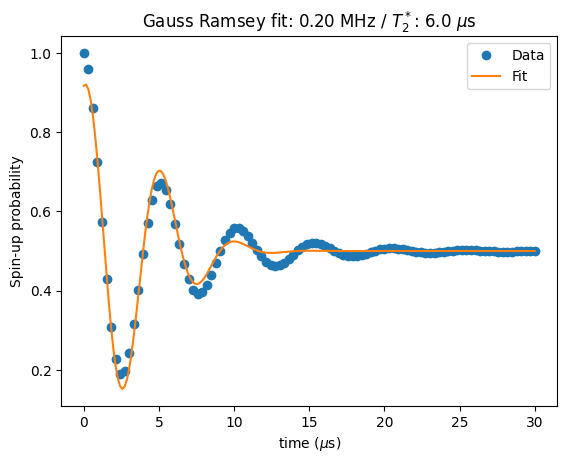

In [79]:
fit_parameters, _ = fit_gauss_ramsey(tlist / 1e6, coherence_q1_ind)
freq_fit = abs(fit_parameters[2] * 1e-6 )
t2star_fit = abs(fit_parameters[1] * 1e6)

plot_gauss_ramsey_fit(tlist / 1e6, coherence_q1_ind, fit_parameters, fig=1)


In [80]:
print(fit_parameters)

[ 4.20846922e-01  6.00959076e-06  1.95590290e+05 -1.43723265e+00
  5.00095508e-01]


In [81]:
t = tlist / 1e6
signal = coherence_q1_ind

In [82]:
# Define the Ramsey function
def ramsey(t, A, T2_star, f, phi, C):
    return A * np.exp(-t/T2_star) * np.cos(2*np.pi*f*t + phi) + C

Fitted T2*: 4.88


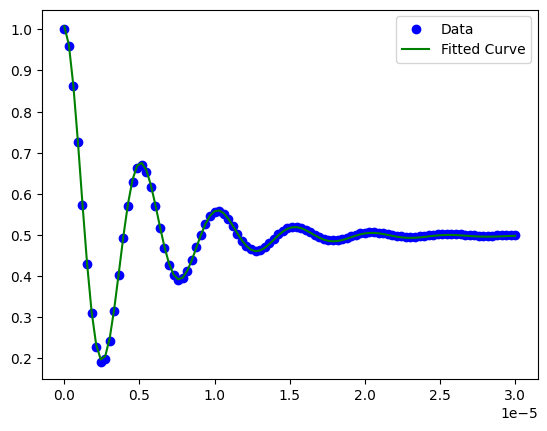

In [83]:
# Perform curve fitting
popt, pcov = curve_fit(ramsey, t, signal, p0=fit_parameters)

# Extract fitted parameters
A_fit, T2_star_fit, f_fit, phi_fit, C_fit = popt
print(f"Fitted T2*: {(T2_star_fit*1e6):.2f}")

# Plot the fitted curve
plt.scatter(t, signal, label="Data", color="blue")
plt.plot(t, ramsey(t, *popt), label="Fitted Curve", color="green")
plt.legend()
plt.show()

In [31]:
print(popt)

[5.00002879e-01 1.09080807e-05 9.99928482e+04 7.51378111e-06
 4.99999927e-01]


C:\Users\jayamao\AppData\Local\Temp\ipykernel_26256\155784351.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_decay, tlist, pop, p0=[1.0, 20, 0])


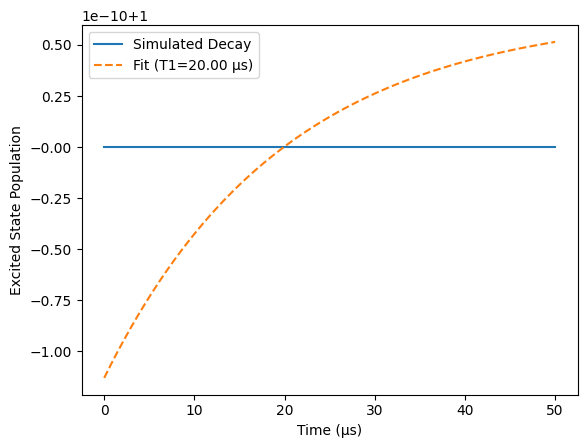

Extracted T1: 20.00 μs


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, sigmaz, sigmam, mesolve, tensor
from scipy.optimize import curve_fit

# Define system parameters
fq = 3.2  # Qubit frequency (GHz)
gamma1 = 1 / 20  # Relaxation rate (1/T1)
tlist = np.linspace(0, 50, 500)  # Time points in μs

# Define operators
sz = sigmaz()
sm = sigmam()

# Hamiltonian (assuming simple qubit model)
H = 2 * np.pi * fq / 2 * sz

# Collapse operator for relaxation (T1 process)
c_ops = [np.sqrt(gamma1) * sz]

# Initial state (excited state)
psi0 = basis(2, 1)

# Solve the Lindblad Master Equation
result = mesolve(H, psi0, tlist, c_ops, [sz])

# Compute population decay
pop = (1 - result.expect[0]) / 2

# Fit T1 decay curve
def exp_decay(t, a, T1, c):
    return a * np.exp(-t / T1) + c

popt, _ = curve_fit(exp_decay, tlist, pop, p0=[1.0, 20, 0])
T1_extracted = popt[1]

# Plot results
plt.plot(tlist, pop, label="Simulated Decay")
plt.plot(tlist, exp_decay(tlist, *popt), '--', label=f"Fit (T1={T1_extracted:.2f} μs)")
plt.xlabel("Time (μs)")
plt.ylabel("Excited State Population")
plt.legend()
plt.show()

print(f"Extracted T1: {T1_extracted:.2f} μs")


In [9]:
print(result.expect[0])

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import Bloch, about, basis, mesolve, sigmam, sigmax, sigmay, sigmaz

%matplotlib inline

In [16]:
# coefficients
delta = 2 * np.pi
g = 0.25

# hamiltonian
H = delta / 2.0 * sigmax()

# list of collapse operators
c_ops = [np.sqrt(g) * sigmaz()]

# initial state
psi0 = basis(2, 0)

# times
tlist = np.linspace(0, 5, 100)

In [17]:
res = mesolve(H, psi0, tlist, c_ops, [sigmaz()])

In [18]:
sz_analytic = np.cos(2 * np.pi * tlist) * np.exp(-tlist * g)

In [19]:
plt.scatter(tlist, res.expect[0], c="r", marker="x", label="mesolve")
plt.plot(tlist, sz_analytic, label="Analytic")
plt.xlabel("Time"), plt.ylabel("<sigma_z>")
plt.legend();

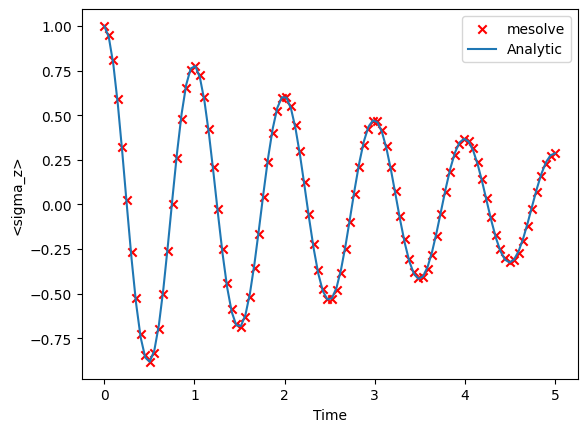

In [20]:
plt.show()

In [21]:
print(res)

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0
    preparation time: 0.0
    run time: 0.015996456146240234
    solver: 'Master Equation Evolution'
    num_collapse: 1
  Time interval: [0.0, 5.0] (100 steps)
  Number of e_ops: 1
  State not saved.
>
